<h2>Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

import dask
import time

import cudf
import cuml
import cupy as cp

import os, wget

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans

import celltypist

from dask_cuda import initialize, LocalCUDACluster
from dask.distributed import Client, default_client

from matplotlib.pyplot import rc_context

import rapids_scanpy_funcs
import utils

import logging
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

sc.settings.n_jobs = 200

cuml.__version__

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.2) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'23.02.00'

<h2>Setting up multi gpu use

In [2]:
import rmm

def set_mem():
    rmm.reinitialize(managed_memory=True)
    cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

In [3]:
preprocessing_gpus=[0, 1, 2, 3]

In [4]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=preprocessing_gpus)
client = Client(cluster)    

set_mem()
client.run(set_mem)

client

To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
State start
  Scheduler at:     tcp://127.0.0.1:40379
  dashboard at:            127.0.0.1:8787
        Start Nanny at: 'tcp://127.0.0.1:42289'
        Start Nanny at: 'tcp://127.0.0.1:40841'
        Start Nanny at: 'tcp://127.0.0.1:41711'
        Start Nanny at: 'tcp://127.0.0.1:39745'
2023-05-26 16:22:28,559 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ri6ddv03', purging
2023-05-26 16:22:28,560 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_u0r9uad', purging
2023-05-26 16:22:28,560 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-26 16:22:28,560 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-26 16:22:28,570 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40379,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:46147,Total threads: 1
Dashboard: http://127.0.0.1:40067/status,Memory: 251.92 GiB
Nanny: tcp://127.0.0.1:42289,


<h2>Preprocessing

<h3>Set the parameters

In [5]:
# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed

MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["CSF1", "PET100", "APOE", "APP", "KCNB1"] # Marker genes for visualization

# filtering genes
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 100 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

n_workers = len(client.scheduler_info()['workers'])

<h3>Load and Preprocess Data</h3>
Below, we load the sparse count matrix from the .h5ad file into GPU using a custom function. While reading the dataset, filters are applied on the count matrix to remove cells with an extreme number of genes expressed. Genes will zero expression in all cells are also eliminated.

The custom function uses Dask to partition data. The above mentioned filters are applied on individual partitions. Usage of Dask along with cupy provides the following benefits:

    Parallelized data loading when multiple GPUs are available
    Ability to partition the data allows pre-processing large datasets

Filters are applied on individual batches of cells. Elementwise or cell-level normalization operations are also performed while reading. For this example, the following two operations are performed:

    Normalize the count matrix so that the total counts in each cell sum to 1e4.
    Log transform the count matrix.



In [6]:
%%time
def partial_post_processor(partial_data):
    partial_data = rapids_scanpy_funcs.normalize_total(partial_data, target_sum=1e4)
    return partial_data.log1p()

dask_sparse_arr, genes, query = rapids_scanpy_funcs.read_with_filter(client,
                                                       "data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad",
                                                       min_genes_per_cell=min_genes_per_cell,
                                                       max_genes_per_cell=max_genes_per_cell,
                                                       partial_post_processor=partial_post_processor)
dask_sparse_arr = dask_sparse_arr.persist()

CPU times: user 6.81 s, sys: 3.47 s, total: 10.3 s
Wall time: 1min 46s


Verify the shape of the resulting sparse matrix:

In [7]:
dask_sparse_arr.shape

(1378211, 35758)


<h3>Select Most Variable Genes</h3>

Before filtering the count matrix, we save the 'raw' expression values of the marker genes to use for labeling cells afterward.


In [8]:
%%time
marker_genes_raw = {}
i = 0
for index in genes[genes.isin(markers)].index.to_arrow().to_pylist():
    marker_genes_raw[markers[i]] = dask_sparse_arr[:, index].compute().toarray().ravel()
    i += 1

CPU times: user 11.5 s, sys: 666 ms, total: 12.1 s
Wall time: 28.3 s


Filter the count matrix to retain only the most variable genes.

In [9]:
%%time

hvg = rapids_scanpy_funcs.highly_variable_genes_filter(client, dask_sparse_arr, genes, n_top_genes=n_top_genes)

genes = genes[hvg]
dask_sparse_arr = dask_sparse_arr[:, hvg]
sparse_gpu_array = dask_sparse_arr.compute()


CPU times: user 3.94 s, sys: 2.56 s, total: 6.5 s
Wall time: 11.8 s


In [10]:
adata = anndata.AnnData(X=dask_sparse_arr.compute().get())
adata.var_names = genes.to_numpy()

In [11]:
adata.raw = adata

In [12]:
import celltypist

In [13]:
celltypist.models.download_models(model = 'Immune_All_High.pkl')

📂 Storing models in /root/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_High.pkl (file exists)


In [14]:
adata = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = False).to_adata()

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 807382 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 1466 features used for prediction
⚖️ Scaling input data
Event loop was unresponsive in Nanny for 3.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 3.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 3.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 3.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause

In [15]:
adata.obs[['predicted_labels', 'conf_score']]

,predicted_labels,conf_score
0,Epithelial cells,0.999980
1,Epithelial cells,0.998895
2,Epithelial cells,1.000000
3,Epithelial cells,1.000000
4,Fibroblasts,1.000000
...,...,...
807377,Double-positive thymocytes,0.999848
807378,Epithelial cells,1.000000
807379,Double-positive thymocytes,0.999998
807380,Double-positive thymocytes,1.000000


In [16]:
predicted_labels = list(adata.obs.predicted_labels)
conf_score = list(adata.obs.conf_score)

del adata


<h3>Regress out confounding factors (number of counts, mitochondrial gene expression)</h3>

We can now perform regression on the count matrix to correct for confounding factors - for example purposes, we use the number of counts and the expression of mitochondrial genes (named starting with mt-).

We now calculate the total counts and the percentage of mitochondrial counts for each cell.


In [17]:
%%time
sparse_gpu_array = sparse_gpu_array.tocsc()

mito_genes = genes.str.startswith(MITO_GENE_PREFIX).values
n_counts = sparse_gpu_array.sum(axis=1)
percent_mito = (sparse_gpu_array[:,mito_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_mito = cp.array(percent_mito).ravel()

CPU times: user 2.74 s, sys: 372 ms, total: 3.11 s
Wall time: 3.01 s


In [18]:
del sparse_gpu_array

And perform regression:

In [19]:
%%time
n_rows = dask_sparse_arr.shape[0]
n_cols = dask_sparse_arr.shape[1]
cols_per_worker = int(n_cols / n_workers)
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: x.todense(), dtype="float32", meta=cp.array(cp.zeros((0,)))).T
dask_sparse_arr = dask_sparse_arr.rechunk((cols_per_worker, n_rows)).persist()
dask_sparse_arr.compute_chunk_sizes()

CPU times: user 531 ms, sys: 264 ms, total: 795 ms
Wall time: 12.6 s


dask.array<rechunk-merge, shape=(4000, 807382), dtype=float32, chunksize=(1000, 807382), chunktype=cupy.ndarray>

In [20]:
%%time
import math
dask_sparse_arr = dask_sparse_arr.map_blocks(lambda x: rapids_scanpy_funcs.regress_out(x.T, n_counts, percent_mito).T, dtype="float32", meta=cp.array(cp.zeros(0,))).T
dask_sparse_arr = dask_sparse_arr.rechunk((math.ceil(n_rows/n_workers), n_cols)).persist()
dask_sparse_arr.compute_chunk_sizes()

2023-05-26 16:29:20,510 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:46147 -> tcp://127.0.0.1:46681
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tornado/iostream.py", line 869, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/usr/local/lib/python3.8/dist-packages/tornado/iostream.py", line 1138, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/distributed/worker.py", line 1767, in get_data
    response = await comm.read(deserializers=serializers)
  File "/usr/local/lib/python3.8/dist-packages/distributed/comm/tcp.py", line 241, in read
    convert_stream_closed_error(self, e)
  File "/usr/local/lib/python3.8/dist-packages/distributed/comm/tcp.py", line 142, in convert_stream_closed_error
  

CPU times: user 8.16 s, sys: 3.58 s, total: 11.7 s
Wall time: 4min 1s


dask.array<rechunk-merge, shape=(807382, 4000), dtype=float32, chunksize=(344553, 4000), chunktype=cupy.ndarray>


<h3>Scale</h3>

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.


In [21]:
%%time
mean = dask_sparse_arr.mean(axis=0)
dask_sparse_arr -= mean
stddev = cp.sqrt(dask_sparse_arr.var(axis=0).compute())
dask_sparse_arr /= stddev
dask_sparse_arr = dask.array.clip(dask_sparse_arr, -10, 10).persist()

del mean, stddev

CPU times: user 734 ms, sys: 251 ms, total: 985 ms
Wall time: 13 s


<h2>Cluster & Visualize


<h3>Reduce</h3>

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.


In [22]:
%%time
from cuml.dask.decomposition import PCA
pca_data = PCA(n_components=50).fit_transform(dask_sparse_arr)
pca_data.compute_chunk_sizes()

Run out-of-band function '_func_set_scheduler_as_nccl_root'
Run out-of-band function '_func_destroy_scheduler_session'


CPU times: user 520 ms, sys: 236 ms, total: 757 ms
Wall time: 12.7 s


dask.array<concatenate, shape=(807382, 50), dtype=float32, chunksize=(344553, 50), chunktype=cupy.ndarray>

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [23]:
%%time
local_pca = pca_data.compute()
X = dask_sparse_arr.compute().get()

CPU times: user 8.81 s, sys: 10.9 s, total: 19.7 s
Wall time: 23.1 s


<h3>Create Anndata

<h4>Load Observations

In [24]:
'''%%time
import h5py

f = h5py.File("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad")

obs = pd.DataFrame()
for i in f["obs"].keys():
    #print(i)
    if i not in ["Hispanic", "Race (choice=American Indian", "Race (choice=Black", "__categories"]:
        obs[i] = np.array(f["obs"][i])

ad = sc.read_h5ad("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad", backed="r")

set_cells = list()
chunk_size = 10000
for chunk, start, end in ad.chunked_X(chunk_size):
    subset_min, _ = sc.pp.filter_cells(anndata.AnnData(chunk), min_genes=min_genes_per_cell, inplace=False)
    subset_max, _ = sc.pp.filter_cells(anndata.AnnData(chunk), max_genes=max_genes_per_cell, inplace=False)
    set_cells = set_cells + list(subset_max * subset_min)
#obs = pd.read_csv("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.csv")
obs["set_cells"] = set_cells
obs = obs.drop(obs[obs.set_cells == False].index)
#obs.to_csv("data/set_cell-obs_final-nuclei.2023-05-05.csv")
'''

'%%time\nimport h5py\n\nf = h5py.File("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad")\n\nobs = pd.DataFrame()\nfor i in f["obs"].keys():\n    #print(i)\n    if i not in ["Hispanic", "Race (choice=American Indian", "Race (choice=Black", "__categories"]:\n        obs[i] = np.array(f["obs"][i])\n\nad = sc.read_h5ad("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad", backed="r")\n\nset_cells = list()\nchunk_size = 10000\nfor chunk, start, end in ad.chunked_X(chunk_size):\n    subset_min, _ = sc.pp.filter_cells(anndata.AnnData(chunk), min_genes=min_genes_per_cell, inplace=False)\n    subset_max, _ = sc.pp.filter_cells(anndata.AnnData(chunk), max_genes=max_genes_per_cell, inplace=False)\n    set_cells = set_cells + list(subset_max * subset_min)\n#obs = pd.read_csv("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.csv")\nobs["set_cells"] = set_cells\nobs = obs.drop(obs[obs.set_cells == False].index)\n#obs.to_csv("data/set_cell-obs_final-nuclei.2023-05-05.csv")\n'

<h4>Add data together

In [25]:
%%time
adata = anndata.AnnData(X=X)
adata.var_names = genes.to_numpy()
adata.obsm["X_pca"] = local_pca.get()
obs = pd.read_csv("data/set_cell-obs_final-nuclei.2023-05-05.csv")
adata.obs = obs
#adata.obs.drop(columns = ["Unnamed: 0"])
adata.obs["predicted_labels"] =  predicted_labels
adata.obs["conf_score"] = conf_score

import h5py
f = h5py.File("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad")
adata.obsm["X_scVI"] = np.array(f["obsm"]["X_scVI"])[list(adata.obs["Unnamed: 0"]), :]
adata.obsm["X_umap"] = np.array(f["obsm"]["X_umap"])[list(adata.obs["Unnamed: 0"]), :]


del obs
del predicted_labels
del conf_score
del pca_data
del dask_sparse_arr

full garbage collection released 3.14 GiB from 146 reference cycles (threshold: 9.54 MiB)


KeyError: "['Unnamed: 0.1'] not found in axis"

<h3>work with data

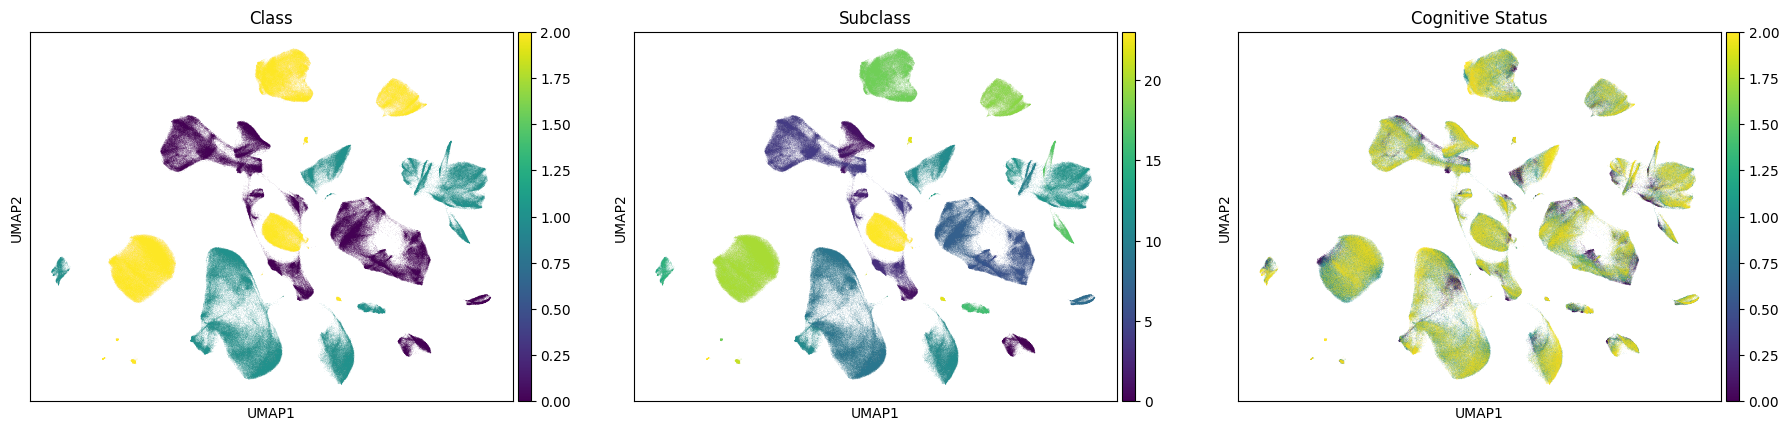

In [105]:
sc.pl.umap(adata, color=["Class", "Subclass", "Cognitive Status"])

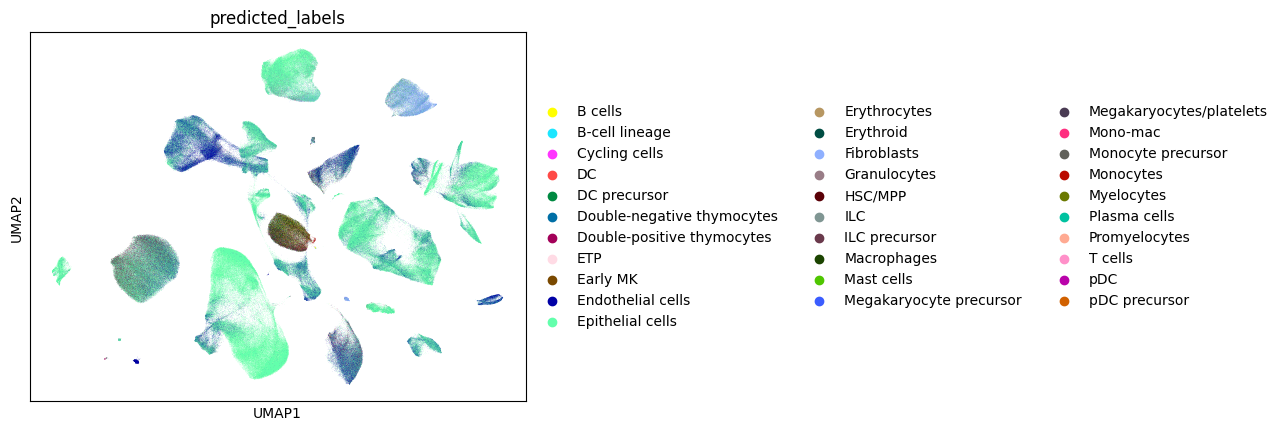

In [128]:
sc.pl.umap(adata, color=["predicted_labels"])

In [92]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

Event loop was unresponsive in Nanny for 11.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 11.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 11.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 11.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 11.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


CPU times: user 45.2 s, sys: 456 ms, total: 45.6 s
Wall time: 35 s


In [99]:
%%time
sc.tl.louvain(adata, flavor='rapids')

Event loop was unresponsive in Nanny for 17.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 17.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 17.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 17.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 17.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


CPU times: user 13.2 s, sys: 4.55 s, total: 17.8 s
Wall time: 17.7 s


In [101]:
# compute clusters using the leiden method and store the results with the name `clusters`
clusters = rapids_scanpy_funcs.leiden(adata, resolution=0.4)
adata.obs["leiden"] = clusters
del clusters

In [104]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

Event loop was unresponsive in Nanny for 16.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 16.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 16.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 16.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 16.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


CPU times: user 16.5 s, sys: 0 ns, total: 16.5 s
Wall time: 16.5 s


In [109]:
#%%time
#with rc_context({"figure.figsize": (8, 8)}):
#    sc.pl.umap(adata, color=["louvain", "Class", "leiden", "Cognitive Status"])

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


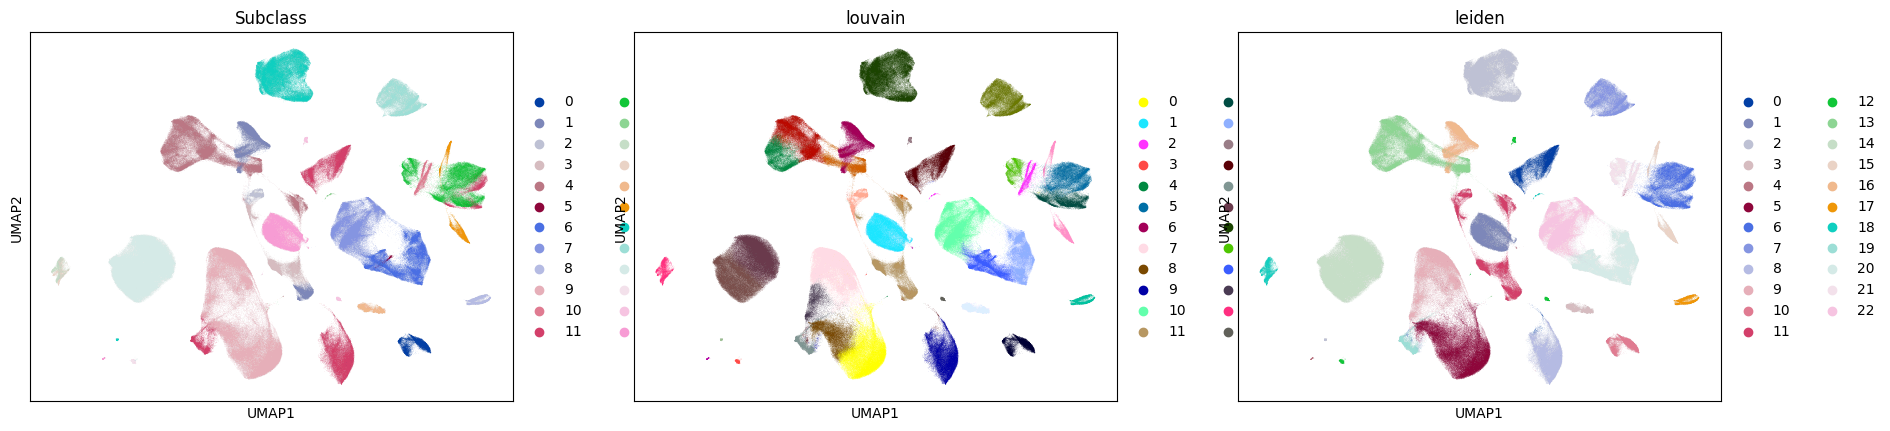

In [166]:
sc.pl.umap(adata, color=["Subclass", "louvain", "leiden"])

In [120]:
#change dtype
adata.obs["Subclass"] = adata.obs["Subclass"].astype("category")

scores, names, original_reference = rapids_scanpy_funcs.rank_genes_groups(adata, "Subclass")

[W] [19:19:27.618206] L-BFGS: max iterations reached
[W] [19:19:27.620688] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


Event loop was unresponsive in Nanny for 28.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 28.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 28.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Nanny for 28.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 28.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [121]:
adata.uns["rank_scores"] = scores
adata.uns["names"] = names

del scores, names, original_reference

In [129]:
alignment = celltypist.harmonize(adata, 'Class', 'predicted_labels')

👀 Detected PCA coordinates in the object, will use these to calculate distances
full garbage collection released 270.86 MiB from 163508 reference cycles (threshold: 9.54 MiB)
🏆 Reordering datasets
🖇 Harmonizing cell types of 0 and 1
🖇 Harmonizing cell types of 2
🖋️ Reannotating cells
✅ Harmonization done!


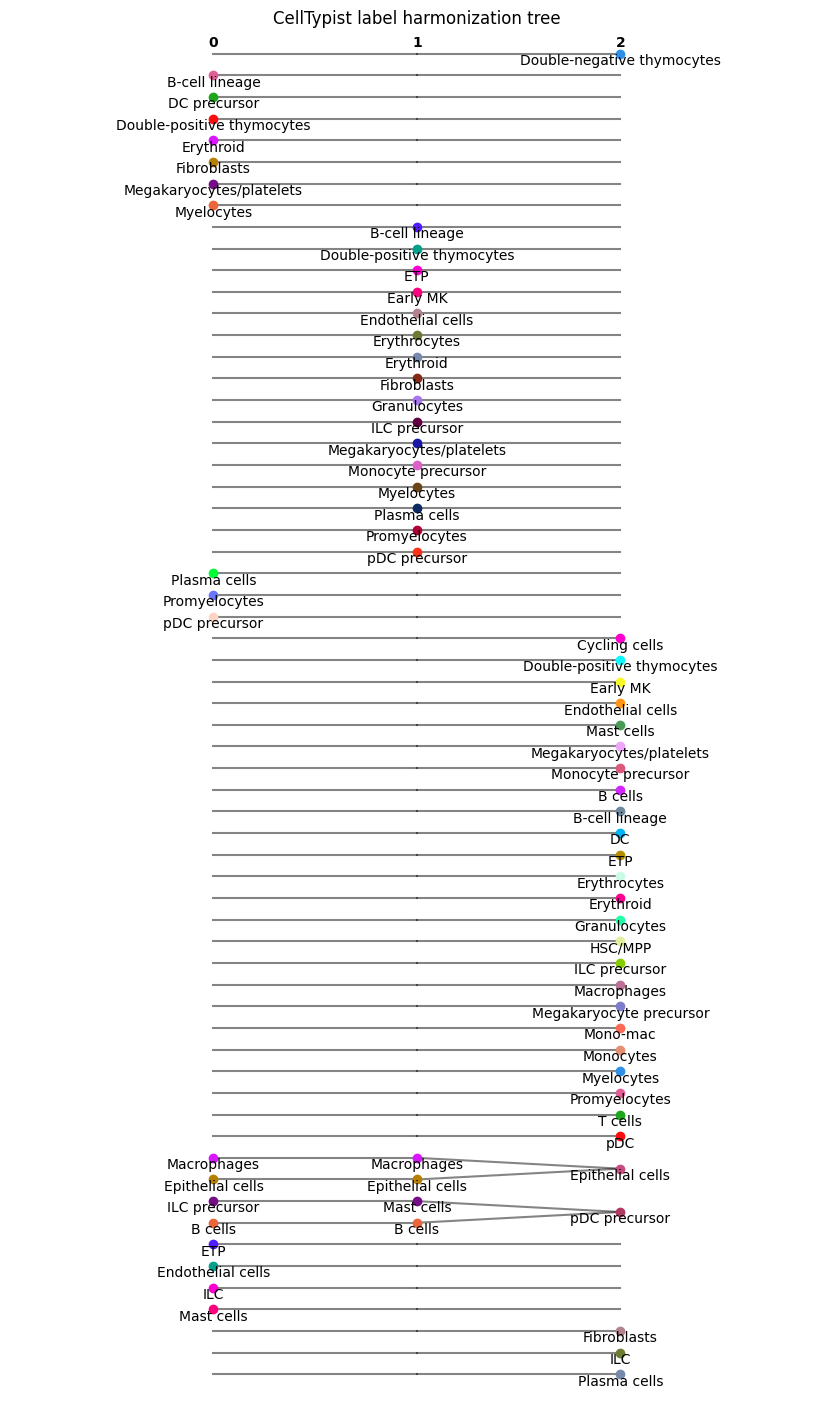

In [130]:
celltypist.treeplot(alignment)

In [131]:
adata.obs[['reannotation', 'group']] = alignment.reannotation[['reannotation', 'group']].loc[adata.obs_names]

... storing 'reannotation' as categorical
... storing 'group' as categorical


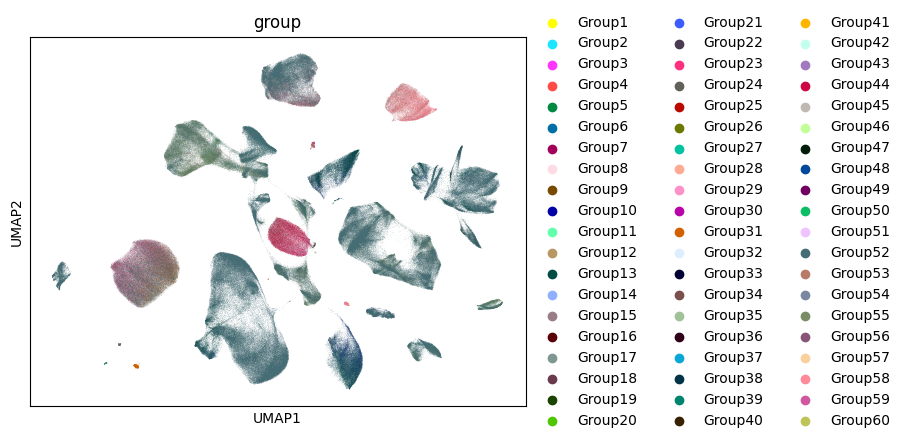

In [132]:
sc.pl.umap(adata, color = 'group')

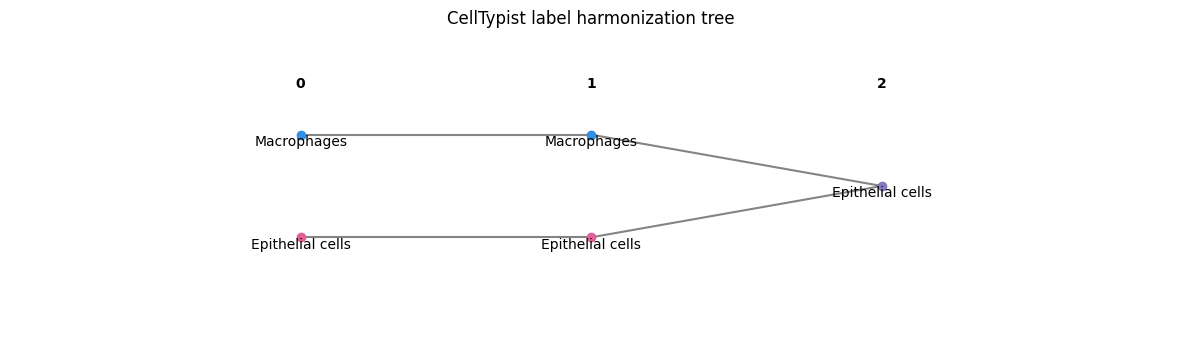

In [136]:
celltypist.treeplot(alignment.relation[alignment.groups == 'Group52'], figsize = [15, 4])#13, 44

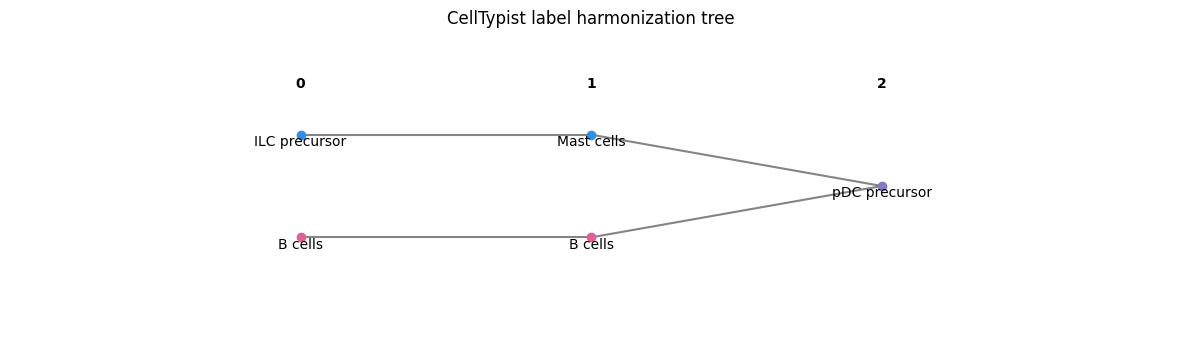

In [137]:
celltypist.treeplot(alignment.relation[alignment.groups == 'Group53'], figsize = [15, 4])#13, 44

['Epithelial cells = Epithelial cells ∈ Epithelial cells'
 'Macrophages = Macrophages ∈ Epithelial cells']


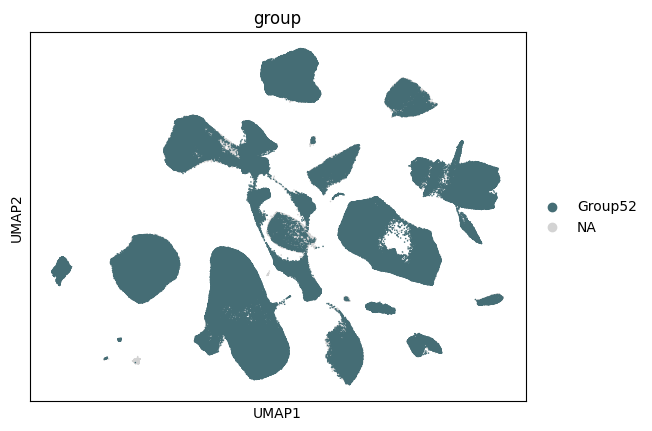

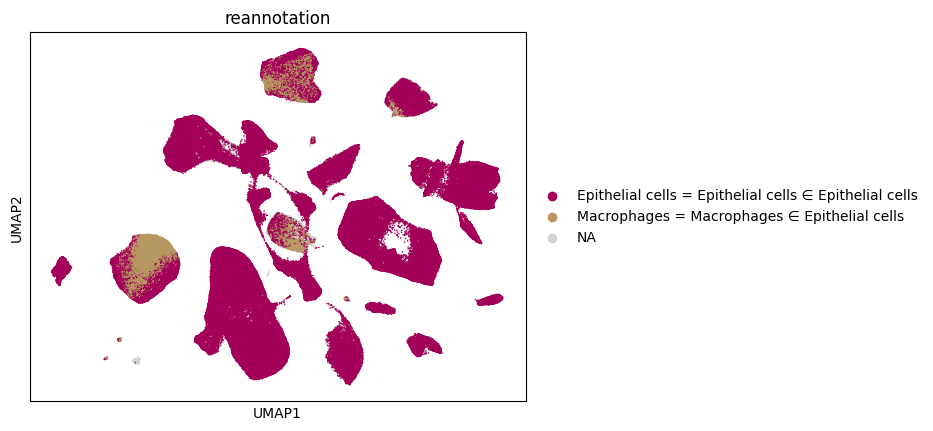

In [142]:
low_cell_types = np.unique(adata.obs.reannotation[adata.obs.group == 'Group52'])
print(low_cell_types)
sc.pl.umap(adata, color = 'group', groups = 'Group52', size = 5)
sc.pl.umap(adata, color = ['reannotation'], groups = list(low_cell_types), size = 5)

['B cells = B cells ∈ pDC precursor'
 'ILC precursor = Mast cells ∈ pDC precursor']


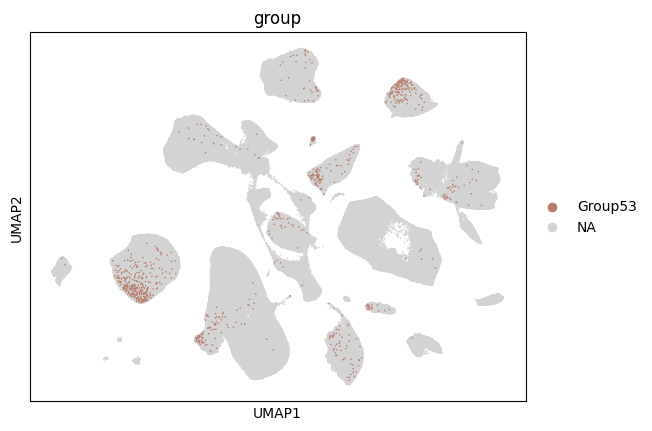

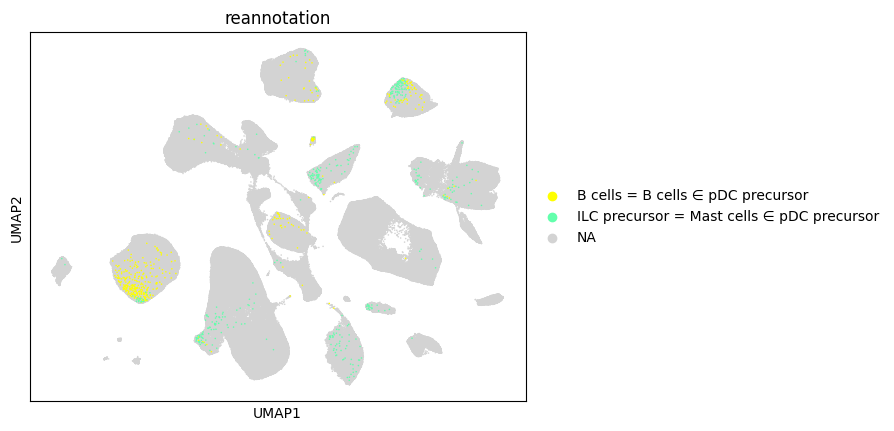

In [143]:
low_cell_types = np.unique(adata.obs.reannotation[adata.obs.group == 'Group53'])
print(low_cell_types)
sc.pl.umap(adata, color = 'group', groups = 'Group53', size = 5)
sc.pl.umap(adata, color = ['reannotation'], groups = list(low_cell_types), size = 5)

In [165]:
import scvelo as scv
import cellrank as cr

In [169]:
scv.tl.velocity(adata)

Event loop was unresponsive in Scheduler for 3.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


computing neighbors


2023-05-28 11:19:55,228 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
full garbage collections took 16% CPU time recently (threshold: 10%)
full garbage collection released 3.24 GiB from 3859982 reference cycles (threshold: 9.54 MiB)
2023-05-28 11:20:10,676 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
full garbage collections took 13% CPU time recently (threshold: 10%)
2023-05-28 11:22:23,183 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
full garbage collections took 10% CPU time recently (threshold: 10%)


    finished (0:04:41) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities


KeyError: 'Ms'

In [168]:
k = cr.tl.transition_matrix(
    adata, weight_connectivities=0.2, softmax_scale=4, show_progress_bar=False
)
k

/tmp/ipykernel_2603/1856528282.py:1: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  k = cr.tl.transition_matrix(


KeyError: 'Compute RNA velocity first as `scvelo.tl.velocity()`.'

In [147]:
sc.tl.paga(adata, groups="predicted_labels")

Worker process 2892 exited with status 1
Closing Nanny at 'tcp://127.0.0.1:41711'. Reason: nanny-close-gracefully
Worker process 2894 exited with status 1
Worker process 2885 exited with status 1
Worker process 2889 exited with status 1
Closing Nanny at 'tcp://127.0.0.1:39745'. Reason: nanny-close-gracefully
Closing Nanny at 'tcp://127.0.0.1:42289'. Reason: nanny-close-gracefully
Closing Nanny at 'tcp://127.0.0.1:40841'. Reason: nanny-close-gracefully
Event loop was unresponsive in Scheduler for 7.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [164]:
sc.pl.paga(adata, threshold=0.015, layout="fr", node_size_scale=4, edge_width_scale=1.5, basis="umap")

TypeError: paga() got an unexpected keyword argument 'basis'

In [149]:
sc.tl.draw_graph(adata)

full garbage collection released 577.38 MiB from 51305 reference cycles (threshold: 9.54 MiB)
Event loop was unresponsive in Scheduler for 13.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 17.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 17.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 3.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 67.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause tim

KeyboardInterrupt: 

In [154]:
sc.pl.draw_graph(adata, color='paul15_clusters', init_pos="paga")

KeyError: 'draw_graph'

In [104]:
merfish = sc.read("data/SEAAD_MTG_MERFISH_all-nuclei.2023-05-08.h5ad")

In [136]:
merfish

AnnData object with n_obs × n_vars = 1321191 × 180
    obs: 'Donor ID', 'Sex', 'Gender', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'specify other race', 'Hispanic/Latino', 'Highest level of education', 'Years of education', 'PMI', 'Fresh Brain Weight', 'Brain pH', 'Overall AD neuropathological Change', 'Thal', 'Braak', 'CERAD score', 'Overall CAA Score', 'Highest Lewy Body Disease', 'Total Microinfarcts (not observed grossly)', 'Total microinfarcts in screening sections', 'Atherosclerosis', 'Arteriolosclerosis', 'LATE', 'Cognitive Status', 'Last CASI Score', 'Interval from last CASI in months', 'Last MMSE Score', 'Interval from last MMSE in months', 'Last MOCA Score', 'Interval from last MOCA in months', 'APOE4 Status', 'Primary Study Name', 'Secondary Study Name', 

In [134]:
merfish.obs["napari_1"]

896178    -7844.098759
222944    -4700.931450
888681    -6726.639800
1080706   -2558.165181
1310397   -2334.945750
              ...     
359783    -5497.588366
152315    -4087.289219
963395    -5741.073352
117952    -2764.825264
305711    -3270.096780
Name: napari_1, Length: 1321191, dtype: float64

full garbage collection released 1.39 GiB from 1324715 reference cycles (threshold: 9.54 MiB)
Event loop was unresponsive in Scheduler for 3.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 4.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 13.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
Event loop was unresponsive in Scheduler for 26.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


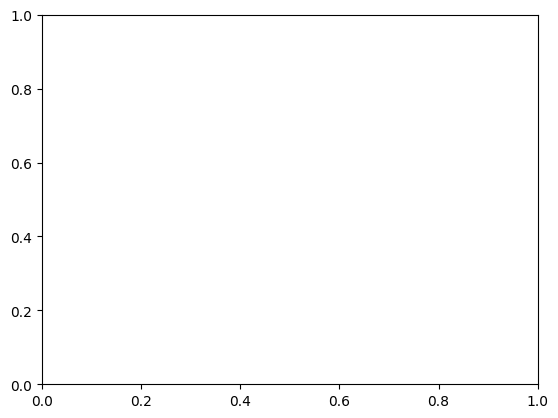

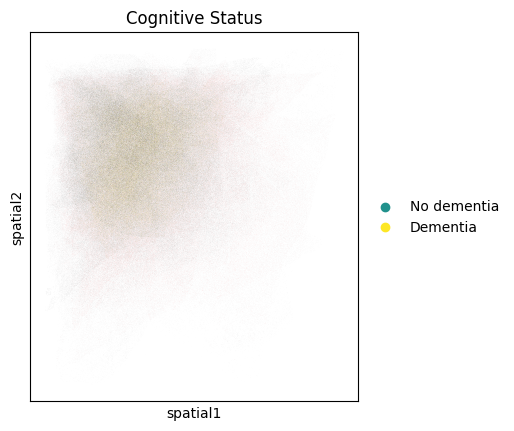

In [154]:
sc.pl.spatial(merfish, color=["Cognitive Status"], spot_size=1)

In [103]:
#adata.write("data/third_try.h5ad")

In [ ]:
#client.shutdown()
#cluster.close()